# Session 4 - VAE and clustering

In this session we will use Auto Encoder to find clusters of realistic string compactifications. [Here](https://blog.keras.io/building-autoencoders-in-keras.html) is a nice tutorial about (Variational) Autoencoder.

As usual we import some packages

In [1]:
import numpy as np
import tensorflow as tf
tfk = tf.keras
import matplotlib.pyplot as plt
import ast

## Standard like models

Our goal is to reproduce the main plot of the following [paper](https://arxiv.org/pdf/2003.13339.pdf). Consider the CICY with configuration matrix:

$$
		\mathcal{M}_{5302} =  \left[
	\begin{array}{c||ccc}
	1 & 0 & 1 & 1 \\
	1 & 0 & 1 & 1 \\
	1 & 1 & 1 & 0 \\
	1 & 1 & 1 & 0 \\
	1 & 1 & 0 & 1 \\
	1 & 1 & 0 & 1
	\end{array}
	\right]^{6,30}_{-48}
$$

and freely acting discrete symmetry of $|\Gamma| = 4$. There exists a classification of all heterotic line bundle models, which can be found [here](http://www-thphys.physics.ox.ac.uk/projects/CalabiYau/linebundlemodels/index.html) (large file 7mb).

We begin with reading in the data:

In [2]:
with open('GUTall.out', 'r') as file:
    data = file.read().replace('\n', '')

In [3]:
data[0:1000]

'(* Mathematica data file for phenomenologically interesting heterotic line bundle SU(5) GUT models               *) (*                           on complete intersection Calabi-Yau manifolds                                       *)(*              Authors: Lara Anderson, Andrei Constantin, James Gray, Andre Lukas, Eran Palti                   *)(* For details see arXiv:nnnn.nnnn                                                                               *)(* save this file to the disk and load into Mathematica with Get["filename"]                                     *)(*****************************************************************************************************************)Print[Style["Heterotic line bundle SU(5) GUT models on Cicys loaded. Authors: Lara Anderson, Andrei Constantin, James Gray, Andre Lukas, Eran Palti\\n Execute ?LineBundleData for help. Details of the string construction can be found at ",12,RGBColor[0.6, 0.3, 0],FontFamily->"Times"],Style[Hyperlink["http://

we do some string manipulations to bring the data into a workable format.

In [4]:
bstring = '{5302, 4} ->'
estring = '}}}'
data = data[data.find(bstring)+len(bstring):]
data = data[:data.find(estring)+len(estring)]
data = data.replace('{', '[').replace('}', ']').replace(' ', '').replace('\t', '')

we create numpy array

In [5]:
models = np.array(ast.literal_eval(data))
# Take transpose wrt last two axes
models = np.swapaxes(models, axis1=1, axis2=2)

In 2003.13339 the authors use the norm of a line bundle sum

$$
K = \left(\sum_{i,a} |q_i^a|^2 \right)^{1/2}
$$

to generate new data following a similar distribution.

In [6]:
def norm(models):
    return np.sqrt(np.sum(np.abs(models)**2, axis=(-1,-2)))

In [7]:
model_norms = norm(models)

Lets, plot the norm for all out line bundle models

In [8]:
def make_norm_plot(norm, stepsize = 0.2):
    interval = np.arange(np.min(norm)-stepsize, np.max(norm)+stepsize, stepsize)
    boxed_norms = np.array([np.sum(interval[i+1] > model_norms[model_norms > interval[i]])
                                    for i in range(len(interval)-1)])
    plt.plot(interval[0:-1], boxed_norms)
    plt.scatter(interval[0:-1], boxed_norms)
    plt.xlabel('norm')
    plt.ylabel('nmodels')

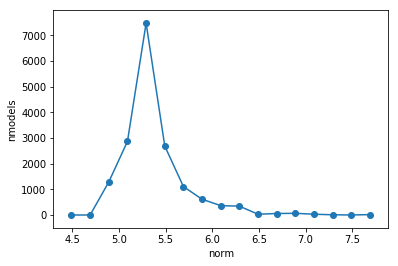

In [9]:
make_norm_plot(model_norms)

We create random models of similar norm and width

In [10]:
def create_random_models(models):
    width = np.std(models)
    rmodels = np.round(np.random.normal(loc=0., scale=width, size=models.shape))
    #fix c1(V) = 0
    rmodels[:,-1,:] = -1*np.sum(rmodels[:,0:4,:], axis=(1))
    return rmodels

In [11]:
rmodels = create_random_models(models)

and plot their norm

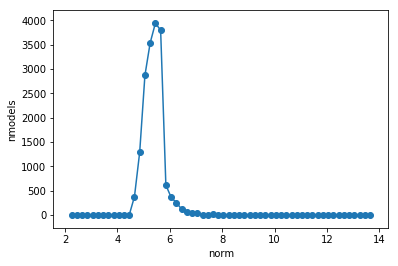

In [12]:
rmodels_norm = norm(rmodels)
make_norm_plot(rmodels_norm)

Now that we've got two distributions of labeled data (model or not a model) we can get started by studying the clustering of standard like models.

We take the same training $K <5$ as in the paper and prepare it for one hot encoding:

In [13]:
training_data = np.concatenate([models[model_norms < 5], rmodels[rmodels_norm < 5]], axis= 0)
training_data = training_data.reshape((len(training_data), -1))+np.max(models)

In [14]:
np.min(training_data), np.max(training_data)

(2.0, 8.0)

In [15]:
depth = (2*np.max(models)+1)
depth

11

In [16]:
x_train = tf.one_hot(training_data, depth)

## Autoencoder

The auto encoder should go down to two latent dimensions to easily visualize the data. Also have a look at autoencoder tutorials [here](https://www.tensorflow.org/tutorials/generative/autoencoder) and [here](https://blog.keras.io/building-autoencoders-in-keras.html).

In [17]:
latent_dim = 2
input_shape = tuple(x_train.shape)[1:]
output_dim = int(np.multiply(*input_shape))
act = tf.nn.leaky_relu
input_shape, output_dim

((30, 11), 330)

building an encoder

In [18]:
def build_encoder(act, latent_dim, verbose = False):
    encoder = tf.keras.Sequential()
    encoder.add(tfk.Input(shape=input_shape))
    encoder.add(tfk.layers.Flatten())
    encoder.add(tfk.layers.Dense(32, activation=act))
    encoder.add(tfk.layers.Dense(16, activation=act))
    encoder.add(tfk.layers.Dense(8, activation=act))
    encoder.add(tfk.layers.Dense(4, activation=act))
    encoder.add(tfk.layers.Dense(latent_dim))
    if verbose:
        encoder.summary()
    return encoder

and the decoder

In [19]:
def build_decoder(act, latent_dim, verbose = False):
    decoder = tf.keras.Sequential()
    decoder.add(tfk.Input(shape=(latent_dim,)))
    decoder.add(tfk.layers.Dense(4, activation=act))
    decoder.add(tfk.layers.Dense(8, activation=act))
    decoder.add(tfk.layers.Dense(16, activation=act))
    decoder.add(tfk.layers.Dense(32, activation=act))
    decoder.add(tfk.layers.Dense(output_dim))
    decoder.add(tfk.layers.Reshape(target_shape=input_shape))
    if verbose:
        decoder.summary()
    return decoder

and now the combined autodecoder

In [20]:
class autoencoder(tfk.Model):
    def __init__(self, encoder, decoder):
        super(autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        
        with tf.GradientTape() as t1:
            x, y = data
            z = encoder(x)
            reconstruction  = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tfk.losses.binary_crossentropy(y, reconstruction)
            )#*output_dim
        grads = t1.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {'loss': reconstruction_loss}
    
    def call(self, inputs, training=False):
        z = self.encoder(inputs)
        out = self.decoder(z)
        return out

In [21]:
encoder = build_encoder(act, latent_dim, verbose=True)
decoder = build_decoder(act, latent_dim, verbose=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 330)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                10592     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
Total params: 11,302
Trainable params: 11,302
Non-trainable params: 0
____________________________________________________

What is [Adam](https://keras.io/api/optimizers/adam/)? Have a look [here](https://arxiv.org/abs/1412.6980).

In [22]:
ae = autoencoder(encoder, decoder)
optimizer_ae = tfk.optimizers.Adam()
ae.compile(optimizer = optimizer_ae)

In [23]:
history = ae.fit(x_train, x_train, epochs=500, batch_size=512, shuffle=True)

Epoch 1/500
5/5 [==============================] - 0s 3ms/step - loss: 0.8012
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.6349
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5978
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5795
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5662
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 0.5551
Epoch 7/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5449
Epoch 8/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5321
Epoch 9/500
5/5 [==============================] - 0s 4ms/step - loss: 0.5177
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.5015
Epoch 11/500
5/5 [==============================] - 0s 3ms/step - loss: 0.4762
Epoch 12/500
5/5 [==============================] - 0s 4ms/step - loss: 0.4504
Epoch 13/500
5/5 [==============================] - 0s 5ms/st

5/5 [==============================] - 0s 3ms/step - loss: 0.3661
Epoch 105/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3657
Epoch 106/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3665
Epoch 107/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3667
Epoch 108/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3659
Epoch 109/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3666
Epoch 110/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3653
Epoch 111/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3672
Epoch 112/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3670
Epoch 113/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3663
Epoch 114/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3668
Epoch 115/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3671
Epoch 116/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 0.3666
Epoch 207/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3644
Epoch 208/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3662
Epoch 209/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3649
Epoch 210/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3666
Epoch 211/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3644
Epoch 212/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3650
Epoch 213/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3664
Epoch 214/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3671
Epoch 215/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3659
Epoch 216/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3656
Epoch 217/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3639
Epoch 218/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 3ms/step - loss: 0.3559
Epoch 309/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3564
Epoch 310/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3554
Epoch 311/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3571
Epoch 312/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3569
Epoch 313/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3560
Epoch 314/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3559
Epoch 315/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3563
Epoch 316/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3563
Epoch 317/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3553
Epoch 318/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3559
Epoch 319/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3559
Epoch 320/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 0.3526
Epoch 411/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3514
Epoch 412/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3524
Epoch 413/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3530
Epoch 414/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3526
Epoch 415/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3523
Epoch 416/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3524
Epoch 417/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3523
Epoch 418/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3532
Epoch 419/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3524
Epoch 420/500
5/5 [==============================] - 0s 3ms/step - loss: 0.3516
Epoch 421/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3518
Epoch 422/500
5/5 [==============================] - 0

Lets go ahead and make some pictures.

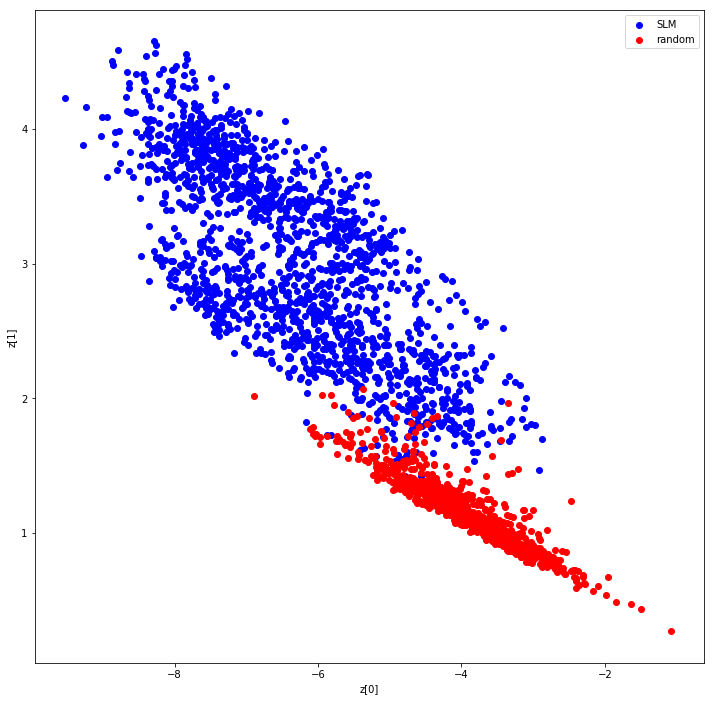

In [24]:
figsize = 12
plt.figure(figsize=(figsize, figsize))

for v, c, l in zip([models[model_norms < 5], rmodels[rmodels_norm < 5]], ['blue', 'red'], ['SLM', 'random']):
    z = encoder.predict(tf.one_hot(v.reshape((len(v), -1))+np.max(models), depth=depth))
    x = z[:, 0]
    y = z[:, 1]
    plt.scatter(x, y, color=c, label=l)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.legend(loc='best')
plt.savefig('ae_slm_norm.pdf')
plt.show()

and more data points

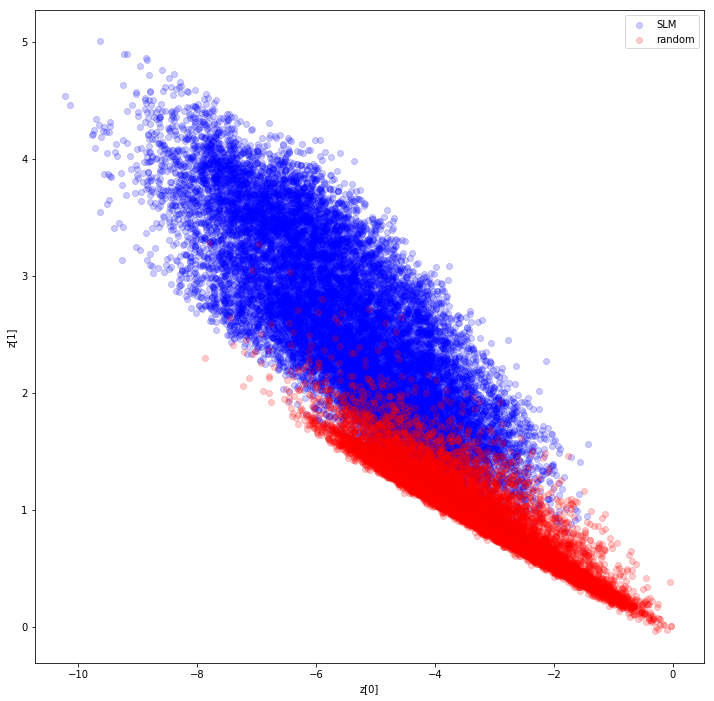

In [25]:
figsize = 12
plt.figure(figsize=(figsize, figsize))
for v, c, l in zip([models, rmodels], ['blue', 'red'], ['SLM', 'random']):
    z = encoder.predict(tf.one_hot(v.reshape((len(v), -1))+np.max(models), depth=depth))
    x = z[:, 0]
    y = z[:, 1]
    plt.scatter(x, y, color=c, label=l, alpha=0.2)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.legend(loc='best')
plt.savefig('ae_slm_all.pdf')
plt.show()

It is interesting to see how the SLM seem to have two distinct clusters. This beahviour seems to disappear when we multiply with the output dimension. I wonder why?

## Variational AutoEncoder

In this section we investiagate what happens when one uses the variational auto encoder. Check out the official tf VAE tutorial [here](https://www.tensorflow.org/tutorials/generative/cvae?hl=en).

In [26]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, alpha=1):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha
        
    def sample(self, z_mean, z_log_var):
        #use reparametrization trick and multiply elementwise with epsilon
        epsilon = tfk.backend.random_normal(shape = (tf.shape(z_mean)[0:2]))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def train_step(self, data):
        
        with tf.GradientTape() as t1:
            x, y = data
            z = self.encoder(x)
            # we get mean and log var
            z_mean = z[:,0:2]
            z_log_var = z[:,2:]
            # we sample a point with the dist defined by the inference model
            sample = self.sample(z_mean, z_log_var)
            # reconstruct
            reconstruction  = self.decoder(sample)
            # regular reconstruct loss.
            reconstruction_loss = self.alpha * output_dim * tf.reduce_mean(
                tfk.losses.binary_crossentropy(y, reconstruction)
            )
            # kl loss to pulls the distr. closer together
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = t1.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {'loss': total_loss, 'rec_loss': reconstruction_loss, 'kl_loss': kl_loss}
    
    def call(self, inputs, training=False):
        z = self.encoder(inputs)
        rec = self.decoder(z)
        return rec

build encoder, decoder

In [27]:
encoder = build_encoder(act, 2*latent_dim, True)
decoder = build_decoder(act, latent_dim, True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 330)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                10592     
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 20        
Total params: 11,312
Trainable params: 11,312
Non-trainable params: 0
__________________________________________________

In [28]:
model = VAE(encoder, decoder, alpha = 0.2)
model.compile(optimizer = tfk.optimizers.Adam())

In [29]:
model.fit(x_train, x_train, epochs=500, batch_size=512)

Epoch 1/500
5/5 [==============================] - 0s 3ms/step - loss: 54.3104 - rec_loss: 54.2165 - kl_loss: 0.0939
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 46.1847 - rec_loss: 46.1332 - kl_loss: 0.0515
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 41.5314 - rec_loss: 41.5077 - kl_loss: 0.0237
Epoch 4/500
5/5 [==============================] - 0s 5ms/step - loss: 38.1505 - rec_loss: 38.1376 - kl_loss: 0.0129
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 34.9432 - rec_loss: 34.9318 - kl_loss: 0.0113
Epoch 6/500
5/5 [==============================] - 0s 5ms/step - loss: 32.7165 - rec_loss: 32.7010 - kl_loss: 0.0155
Epoch 7/500
5/5 [==============================] - 0s 4ms/step - loss: 31.0279 - rec_loss: 31.0079 - kl_loss: 0.0200
Epoch 8/500
5/5 [==============================] - 0s 4ms/step - loss: 29.6985 - rec_loss: 29.6756 - kl_loss: 0.0229
Epoch 9/500
5/5 [==============================] - 0s 4ms/step -

5/5 [==============================] - 0s 3ms/step - loss: 22.4935 - rec_loss: 22.4705 - kl_loss: 0.0230
Epoch 71/500
5/5 [==============================] - 0s 4ms/step - loss: 22.3677 - rec_loss: 22.3445 - kl_loss: 0.0232
Epoch 72/500
5/5 [==============================] - 0s 4ms/step - loss: 22.4631 - rec_loss: 22.4412 - kl_loss: 0.0220
Epoch 73/500
5/5 [==============================] - 0s 4ms/step - loss: 22.3705 - rec_loss: 22.3500 - kl_loss: 0.0205
Epoch 74/500
5/5 [==============================] - 0s 3ms/step - loss: 22.4573 - rec_loss: 22.4386 - kl_loss: 0.0187
Epoch 75/500
5/5 [==============================] - 0s 4ms/step - loss: 22.3900 - rec_loss: 22.3727 - kl_loss: 0.0172
Epoch 76/500
5/5 [==============================] - 0s 4ms/step - loss: 22.3510 - rec_loss: 22.3355 - kl_loss: 0.0155
Epoch 77/500
5/5 [==============================] - 0s 4ms/step - loss: 22.4066 - rec_loss: 22.3919 - kl_loss: 0.0147
Epoch 78/500
5/5 [==============================] - 0s 4ms/step - los

5/5 [==============================] - 0s 4ms/step - loss: 21.8246 - rec_loss: 21.7789 - kl_loss: 0.0457
Epoch 140/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8436 - rec_loss: 21.7990 - kl_loss: 0.0446
Epoch 141/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8473 - rec_loss: 21.8011 - kl_loss: 0.0462
Epoch 142/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8293 - rec_loss: 21.7774 - kl_loss: 0.0519
Epoch 143/500
5/5 [==============================] - 0s 3ms/step - loss: 21.8388 - rec_loss: 21.7855 - kl_loss: 0.0533
Epoch 144/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8268 - rec_loss: 21.7747 - kl_loss: 0.0521
Epoch 145/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8556 - rec_loss: 21.8064 - kl_loss: 0.0492
Epoch 146/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8888 - rec_loss: 21.8429 - kl_loss: 0.0459
Epoch 147/500
5/5 [==============================] - 0s 4ms/st

Epoch 208/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7588 - rec_loss: 21.6910 - kl_loss: 0.0678
Epoch 209/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7842 - rec_loss: 21.7157 - kl_loss: 0.0685
Epoch 210/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7787 - rec_loss: 21.7118 - kl_loss: 0.0669
Epoch 211/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8007 - rec_loss: 21.7318 - kl_loss: 0.0689
Epoch 212/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8218 - rec_loss: 21.7508 - kl_loss: 0.0710
Epoch 213/500
5/5 [==============================] - 0s 3ms/step - loss: 21.7061 - rec_loss: 21.6381 - kl_loss: 0.0680
Epoch 214/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7296 - rec_loss: 21.6628 - kl_loss: 0.0669
Epoch 215/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7008 - rec_loss: 21.6358 - kl_loss: 0.0650
Epoch 216/500
5/5 [=============================

5/5 [==============================] - 0s 4ms/step - loss: 21.7563 - rec_loss: 21.6644 - kl_loss: 0.0919
Epoch 277/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8215 - rec_loss: 21.7279 - kl_loss: 0.0936
Epoch 278/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8393 - rec_loss: 21.7437 - kl_loss: 0.0957
Epoch 279/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8551 - rec_loss: 21.7549 - kl_loss: 0.1002
Epoch 280/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7918 - rec_loss: 21.6915 - kl_loss: 0.1003
Epoch 281/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8164 - rec_loss: 21.7170 - kl_loss: 0.0994
Epoch 282/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8592 - rec_loss: 21.7578 - kl_loss: 0.1014
Epoch 283/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8183 - rec_loss: 21.7177 - kl_loss: 0.1006
Epoch 284/500
5/5 [==============================] - 0s 4ms/st

Epoch 345/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7417 - rec_loss: 21.5920 - kl_loss: 0.1497
Epoch 346/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7482 - rec_loss: 21.6005 - kl_loss: 0.1477
Epoch 347/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7885 - rec_loss: 21.6346 - kl_loss: 0.1540
Epoch 348/500
5/5 [==============================] - 0s 4ms/step - loss: 21.6768 - rec_loss: 21.5267 - kl_loss: 0.1501
Epoch 349/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7617 - rec_loss: 21.6019 - kl_loss: 0.1598
Epoch 350/500
5/5 [==============================] - 0s 4ms/step - loss: 21.6755 - rec_loss: 21.5157 - kl_loss: 0.1597
Epoch 351/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7731 - rec_loss: 21.6155 - kl_loss: 0.1576
Epoch 352/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7583 - rec_loss: 21.5980 - kl_loss: 0.1603
Epoch 353/500
5/5 [=============================

5/5 [==============================] - 0s 4ms/step - loss: 21.8949 - rec_loss: 21.7516 - kl_loss: 0.1433
Epoch 414/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7860 - rec_loss: 21.6349 - kl_loss: 0.1511
Epoch 415/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8836 - rec_loss: 21.7238 - kl_loss: 0.1598
Epoch 416/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8024 - rec_loss: 21.6375 - kl_loss: 0.1649
Epoch 417/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8468 - rec_loss: 21.6824 - kl_loss: 0.1644
Epoch 418/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8211 - rec_loss: 21.6555 - kl_loss: 0.1656
Epoch 419/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8469 - rec_loss: 21.6758 - kl_loss: 0.1711
Epoch 420/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8147 - rec_loss: 21.6444 - kl_loss: 0.1703
Epoch 421/500
5/5 [==============================] - 0s 4ms/st

Epoch 482/500
5/5 [==============================] - 0s 4ms/step - loss: 21.6546 - rec_loss: 21.4126 - kl_loss: 0.2420
Epoch 483/500
5/5 [==============================] - 0s 4ms/step - loss: 21.6532 - rec_loss: 21.4083 - kl_loss: 0.2449
Epoch 484/500
5/5 [==============================] - 0s 4ms/step - loss: 21.6815 - rec_loss: 21.3993 - kl_loss: 0.2823
Epoch 485/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7590 - rec_loss: 21.3875 - kl_loss: 0.3715
Epoch 486/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8679 - rec_loss: 21.4505 - kl_loss: 0.4174
Epoch 487/500
5/5 [==============================] - 0s 3ms/step - loss: 21.8291 - rec_loss: 21.4070 - kl_loss: 0.4221
Epoch 488/500
5/5 [==============================] - 0s 4ms/step - loss: 21.8586 - rec_loss: 21.4525 - kl_loss: 0.4060
Epoch 489/500
5/5 [==============================] - 0s 4ms/step - loss: 21.7970 - rec_loss: 21.4183 - kl_loss: 0.3787
Epoch 490/500
5/5 [=============================

plot some models

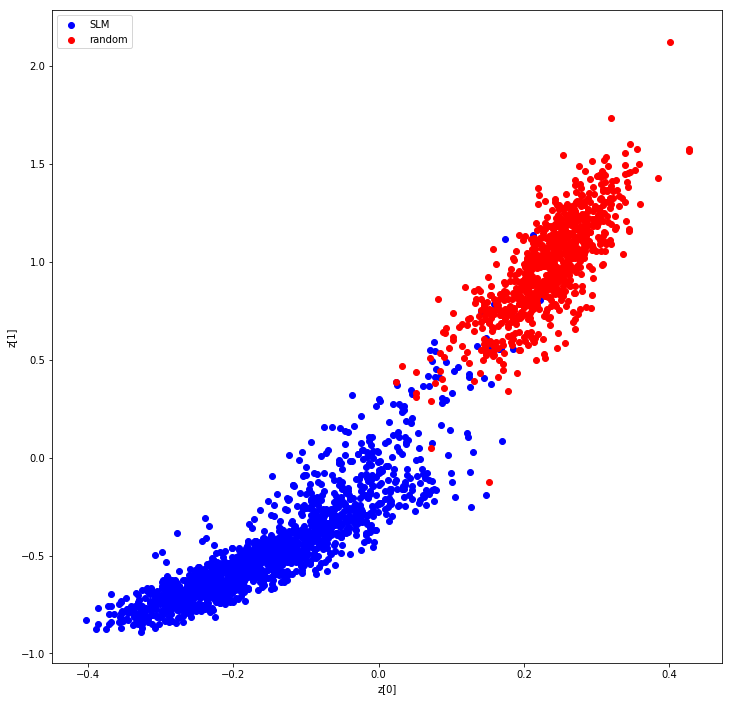

In [30]:
figsize = 12
plt.figure(figsize=(figsize, figsize))

for v, c, l in zip([models[model_norms < 5], rmodels[rmodels_norm < 5]], ['blue', 'red'], ['SLM', 'random']):
    z = encoder.predict(tf.one_hot(v.reshape((len(v), -1))+np.max(models), depth=depth))
    x = z[:, 0]
    y = z[:, 1]
    plt.scatter(x, y, color=c, label=l)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.legend(loc='best')
plt.savefig('vae_slm_norm.pdf')
plt.show()

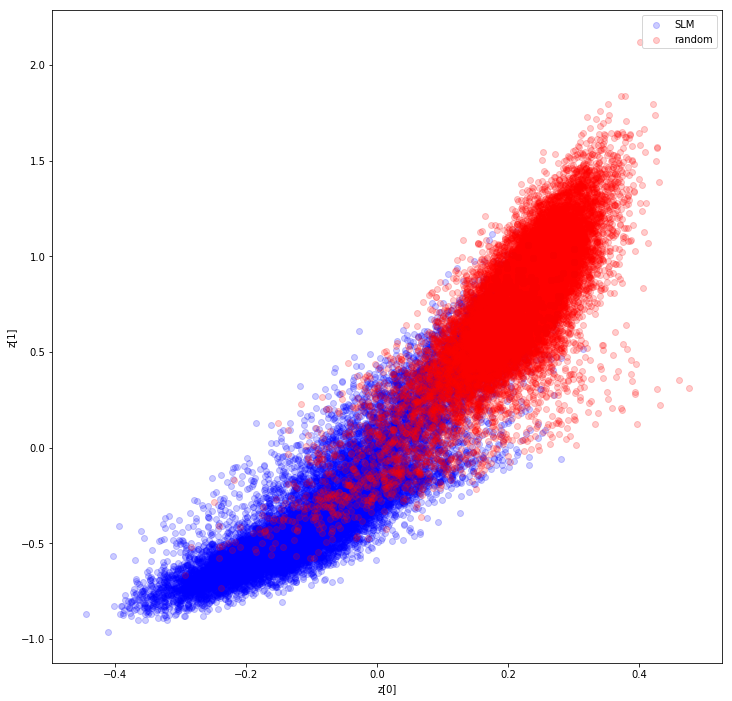

In [31]:
figsize = 12
plt.figure(figsize=(figsize, figsize))
for v, c, l in zip([models, rmodels], ['blue', 'red'], ['SLM', 'random']):
    z = encoder.predict(tf.one_hot(v.reshape((len(v), -1))+np.max(models), depth=depth))
    x = z[:, 0]
    y = z[:, 1]
    plt.scatter(x, y, color=c, label=l, alpha=0.2)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.legend(loc='best')
plt.savefig('vae_slm_all.pdf')
plt.show()

We observe that the addition of the KL loss pulls the two SLM distributions closer together. In general all points are pulled closer to (0,0) as we assume $p(z) = \mathcal{N}(0,1)$.

### Deeper look at rmodel

Let's have a look at the random norm data. How many of those have positive and negative signs per line bundle (necessary condition for stability)?

In [32]:
nsign = np.logical_and.reduce(np.logical_or.reduce(np.where(np.sign(rmodels) == -1, True, False), axis=-1), axis=-1)
psign = np.logical_and.reduce(np.logical_or.reduce(np.where(np.sign(rmodels) == 1, True, False), axis=-1), axis=-1)

In [33]:
both = np.sum(np.logical_and.reduce(np.vstack([nsign, psign]).T, axis=-1))

percentage?

In [34]:
both/len(rmodels)

0.3590513012868602

### Sampling models

Let's sample some models and see how they look like.

In [35]:
z0 = -0.2
z0sigma = 0.5
z1 = -0.5
z1sigma = 0.5
samples = np.vstack([np.random.normal(z0, z0sigma, 100),
                    np.random.normal(z1, z1sigma, 100)]).T

In [36]:
def generateV(decoder, samples):
    V = decoder(samples)
    V = np.argmax(tf.nn.softmax(V).numpy(), axis=-1)-5
    return V.reshape((-1,5,6))

In [37]:
generateV(decoder, samples[0:20])

array([[[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0]],

       [[-1,  0,  0,  0,  0,  1],
        [ 0,  0, -1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
    

## Exercises

ML:

1. Play around with the alpha coefficient of the VAE. See how the distributions get pulled closer together or pushed further appart.
2. Sample some models with the VAE. Are they reasonable (wrt necessary stability for example)?
    1. Can we use the VAE to actually generate data?
    2. Try more latent dimensions? How to study the [clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)?

Physics:
1. Investigate the apparently two distinct distributions for the SLM in the autoencoder. What do the models respectively look like? Has one set more (or less) Higgs multiplets maybe? Or just higher charges?
2. What happens if we improve the training data? Use random samples of similar norm with slope stable line bundles.
3. What happens if we use more training data? Random samples are easily generated. We can apply permutation operations on the SLMs to get more of them.

ML:
1. There are discrete variational auto encoders that exist. See [here](https://arxiv.org/abs/1609.02200) and [here](https://arxiv.org/abs/1711.00937). Implement and study!